In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Create some sample data:

In [2]:
num_dxs = 5
num_findings = 10
avg_ddx_length = 3
ddx_max_length = 5 # this is the max length our graphical model can handle.
sample_size = 10

In [3]:
_W = np.random.randn(num_dxs, num_findings)

In [4]:
def generate_random_case(num_dxs, num_findings, avg_ddx_length, w):
    """
    Generates a random case.

    Parameters:
        num_dxs (:class:`int`): the number of possible diagnoses
        num_findings (:class:`int`): the number of possible findings
        avg_ddx_length (:class:`int`): the average number of diagnoses in a differential
        W (:class:`np.array`): a weight matrix which correlates findings and diagnoses

    Returns:
        2-:class:`tuple` whose first component is a list of diagnoses, and whose second component is a list 
        of findings present.
    """

    def invlogit(x):
        return 1. / (1 + np.exp(-x))

    hidden_x = np.random.laplace(loc=0., scale=1., size=num_dxs)

    findings_hot = np.random.binomial(n=1, p=invlogit(np.dot(hidden_x,w)))
    findings = [i for i in range(num_findings) if findings_hot[i] == 1]

    ddx_length = np.random.poisson(avg_ddx_length)

    from heapq import nlargest
    ddx = nlargest(ddx_length, range(num_dxs), key=lambda i: hidden_x[i])

    return (ddx, findings)

In [5]:
minibatch = []
for _ in range(sample_size):
    minibatch.append(generate_random_case(num_dxs,
                                          num_findings,
                                          avg_ddx_length,
                                          _W))


Ok, now we write code to process the data (so that we can feed it to our graphical model)

In [6]:
def _create_diff_tensor_a(minibatch_size, num_dxs):
    return np.tile(np.eye(num_dxs)[:, :, np.newaxis] - np.eye(num_dxs)[:, np.newaxis, :], [minibatch_size, 1, 1, 1])

def _create_reordered_diff_tensor_a(ddx_max_length, ddxs_extended):
    minibatch_size = len(ddxs_extended)
    num_dxs = len(ddxs_extended[0])
    assert ddx_max_length <= num_dxs, "ddx_max_length: %d, num_dxs: %d"%(ddx_max_length,num_dxs)
    diff_tensor = np.zeros([minibatch_size,num_dxs,ddx_max_length,num_dxs])
    for n in range(minibatch_size):
        assert len(ddxs_extended[n]) == num_dxs,\
            "for each n, need len(ddxs_extended[n]) == len(ddxs_extended[0]), but \n"+\
            "len(ddxs_extended[%d])==%d! and len(ddxs_extended[0])==%d"\
            %(n,len(ddxs_extended[n]),len(ddxs_extended[0]))
        for i in range(ddx_max_length):
            for j in range(num_dxs):
                diff_tensor[n,ddxs_extended[n][i],i,j] +=1
        for i in range(num_dxs):
            for j in range(ddx_max_length):
                diff_tensor[n,ddxs_extended[n][i],j,i] -=1
    return diff_tensor


def _create_first_axes_reordered_diff_tensor_a(ddx_max_length, ddxs_extended):
    minibatch_size = len(ddxs_extended)
    num_dxs = len(ddxs_extended[0])
    assert ddx_max_length <= num_dxs, "ddx_max_length: %d, num_dxs: %d"%(ddx_max_length,num_dxs)
    diff_tensor = np.zeros([minibatch_size,num_dxs,ddx_max_length,num_dxs])
    for n in range(minibatch_size):
        assert len(ddxs_extended[n]) == num_dxs,\
            "for each n, need len(ddxs_extended[n]) == len(ddxs_extended[0]), but \n"+\
            "len(ddxs_extended[%d])==%d! and len(ddxs_extended[0])==%d"\
            %(n,len(ddxs_extended[n]),len(ddxs_extended[0]))
        for i in range(ddx_max_length):
            for j in range(num_dxs):
                diff_tensor[n,ddxs_extended[n][i],i,j] +=1
        for i in range(num_dxs):
            for j in range(ddx_max_length):
                diff_tensor[n,i,j,i] -=1
    return diff_tensor

def _create_order_projection_tensor(ddx_max_length, ddxs_extended):
    minibatch_size = len(ddxs_extended)
    num_dxs = len(ddxs_extended[0])
    assert ddx_max_length <= num_dxs, "ddx_max_length: %d, num_dxs: %d"%(ddx_max_length,num_dxs)
    reord_proj_tensor = np.zeros([minibatch_size,num_dxs,ddx_max_length])
    for n in range(minibatch_size):
        assert len(ddxs_extended[n]) == num_dxs,\
            "for each n, need len(ddxs_extended[n]) == len(ddxs_extended[0]), but \n"+\
            "len(ddxs_extended[%d])==%d! and len(ddxs_extended[0])==%d"\
            %(n,len(ddxs_extended[n]),len(ddxs_extended[0]))
        for i in range(ddx_max_length):
            reord_proj_tensor[n,ddxs_extended[n][i],i] +=1
    return reord_proj_tensor


def _prepare_data_batch(data, num_dxs, num_findings, ddx_max_length):
    ddx_max_length = min(ddx_max_length,num_dxs) # ensure ddx_max_length is a lower bound.

    from itertools import ifilterfalse
    
    ddxs = []
    ddxs_extended = []
    ddx_lens = []
    findings_hot_list = []
    for ddx, findings in data:
        ddx_extended = ddx + list(ifilterfalse(ddx.__contains__, range(num_dxs)))
        ddxs.append(ddx_extended)
        ddx_lens.append(min(ddx_max_length, len(ddx)))

        findings_hot = np.zeros(num_findings, dtype=np.int)
        findings_hot[findings] = 1
        findings_hot_list.append(findings_hot)

    N = len(ddxs)
    reordered_diff_tensor = _create_first_axes_reordered_diff_tensor_a(ddx_max_length,ddxs)
    
    reord_proj_tensor = _create_order_projection_tensor(ddx_max_length,ddxs)

    indicator_array = np.ma.ones([N,ddx_max_length,num_dxs])
    for n in range(N):
        for i in range(0,ddx_max_length):
            for j in range(i):
                indicator_array[n,i,ddxs[n][j]] = 0
            indicator_array[n,i,ddxs[n][i]] = np.ma.masked

    for n,cur_ddx_len in enumerate(ddx_lens):
        indicator_array[n,cur_ddx_len:,:] = np.ma.masked

    return (indicator_array, reordered_diff_tensor, np.array(findings_hot_list), reord_proj_tensor)


In [7]:
data = minibatch
preped_data = _prepare_data_batch(data,num_dxs,num_findings,ddx_max_length)
dx_order_indicator_array_data, diff_tensor_data, findings_data, reord_proj_tensor = preped_data

Code the probabilisitic model in pymc3:

In [8]:
from pymc3 import Model, Categorical, Bernoulli, Normal, Laplace, Dirichlet, Uniform, find_MAP
import theano.tensor as tt
#from pymc3.math import sigmoid

In [9]:
def _build_graphical_model(dx_order_indicator_array_data, diff_tensor_data, findings_data):
        """
        Builds the graphical model and ties the observable variables to the data. You can pass a batch of 
        :class:`int` `size` data; with :class:`int` `num_dxs` possible diagnoses, :class:`int` `num_findings`
        possible findings, and :class:`int` `ddx_max_length` maximum diagnoses in a given differential.
    
        Parameters:
            dx_order_indicator_array_data (:class:`np.array`): should be of shape 
                [`size`,`ddx_max_length`,`num_dxs`].
            diff_tensor_data (:class:`np.array`): should be of shape 
                [`size`,`num_dxs`,`ddx_max_length`,`num_dxs`].
            findings_data (:class:`np.array`): should be of shape 
                [`size`,`num_findings`]. 
    
        Returns:
            4-:tuple: containing (x, dx_order, W, findings), where
                x (:class:`Normal`): are hidden variables
                dx_order (:class:`Bernoulli`): indicate the order of diagnoses in the differential
                W (:class:`Normal`): is a matrix of parameters relating diagnoses to findings
                findings (:class:`Bernoulli`): indicate the presence of findings
    
        """
        # sigmoid function
        def invlogit(x):
            return 1. / (1 + tt.exp(-x))

        size, ddx_max_length, num_dxs = dx_order_indicator_array_data.shape
        num_findings = findings_data.shape[1]

        x = Normal("x", mu=0, sd=10, shape=[size, num_dxs])
        dx_order_p = invlogit(tt.batched_tensordot(x, diff_tensor_data,axes=[1,1]))
        dx_order = Bernoulli("dx_order", p=dx_order_p, observed=dx_order_indicator_array_data)

        W = Normal('W', mu=0., sd=10., shape=[num_dxs, num_findings])
        
        findings_p = invlogit(tt.tensordot(x, W, axes=[1,0]))
        findings = Bernoulli("findings", findings_p, observed=findings_data)

        return (x, dx_order, W, findings)

def _sp_build_graphical_model(dx_order_indicator_array_data, reord_proj_tensor, findings_data):
    """
    Builds the graphical model and ties the observable variables to the data. You can pass a batch of 
    :class:`int` `size` data; with :class:`int` `num_dxs` possible diagnoses, :class:`int` `num_findings`
    possible findings, and :class:`int` `ddx_max_length` maximum diagnoses in a given differential.

    Parameters:
        dx_order_indicator_array_data (:class:`np.array`): should be of shape 
            [`size`,`ddx_max_length`,`num_dxs`].
        diff_tensor_data (:class:`np.array`): should be of shape 
            [`size`,`num_dxs`,`ddx_max_length`,`num_dxs`].
        findings_data (:class:`np.array`): should be of shape 
            [`size`,`num_findings`]. 

    Returns:
        4-:tuple: containing (x, dx_order, W, findings), where
            x (:class:`Normal`): are hidden variables
            dx_order (:class:`Bernoulli`): indicate the order of diagnoses in the differential
            W (:class:`Normal`): is a matrix of parameters relating diagnoses to findings
            findings (:class:`Bernoulli`): indicate the presence of findings

    """
    # sigmoid function
    def invlogit(x):
        return 1. / (1 + tt.exp(-x))

    size, ddx_max_length, num_dxs = dx_order_indicator_array_data.shape
    num_findings = findings_data.shape[1]

    x = Normal("x", mu=0, sd=10, shape=[size, num_dxs])
    dx_order_s_1 = tt.batched_tensordot(x, reord_proj_tensor,axes=[1,1])
    dx_order_s_1 = tt.reshape(dx_order_s_1,[size,ddx_max_length,1])
    dx_order_s_2 = tt.reshape(x,[size,1,num_dxs])
    dx_order_p = invlogit(tt.tile(dx_order_s_1,[1,1,num_dxs])-tt.tile(dx_order_s_2,[1,ddx_max_length,1]))
    dx_order = Bernoulli("dx_order", p=dx_order_p, observed=dx_order_indicator_array_data)

    W = Normal('W', mu=0., sd=10., shape=[num_dxs, num_findings])

    findings_p = invlogit(tt.tensordot(x, W, axes=[1,0]))
    findings = Bernoulli("findings", findings_p, observed=findings_data)

    return (x, dx_order, W, findings)

In [10]:
with Model() as med_model:
    x, dx_order, W, findings = _sp_build_graphical_model(dx_order_indicator_array_data,
                                                      reord_proj_tensor,
                                                      findings_data)
    
    

  Fit the model (using a MAP estimate - really this is EM, but ok...):

In [11]:
map_estimate = find_MAP(model=med_model)

Optimization terminated successfully.
         Current function value: 400.545116
         Iterations: 242
         Function evaluations: 260
         Gradient evaluations: 258


Compare the estimate to the generating parameters...

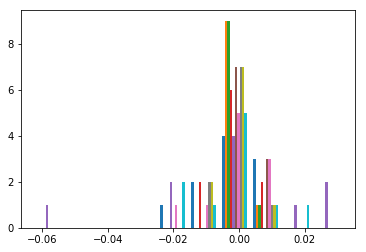

In [12]:
plt.hist(1./(1+np.exp(-map_estimate['x'].dot(map_estimate['W'])))
         -findings_data)
plt.show()

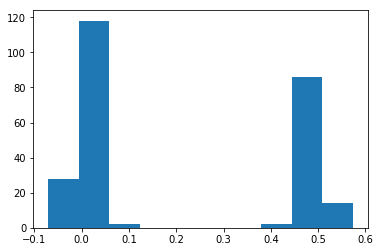

In [13]:
comparison = 1./(1+np.exp(-np.einsum('ij,ijkl->ikl',map_estimate['x'],diff_tensor_data)))-dx_order_indicator_array_data
plt.hist(comparison.reshape([-1]))
plt.show()

In [16]:
map_estimate['dx_order_missing']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])